In [1]:
### Data보기
%matplotlib inline
# python libraties
import os, itertools, cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2

In [2]:
data_path = '../input/data'
train_data_path = glob(os.path.join(data_path,'train','images','*','*'))
val_data_path = glob(os.path.join(data_path,'eval','images','*'))

In [3]:
train_data_path = sorted(train_data_path)
TRUE_LABELS = ['wear-M-30', 'wear-M-3060','wear-M-60',
                   'wear-F-30', 'wear-F-3060','wear-F-60',
                   'incor-M-30', 'incor-M-3060','incor-M-60',
                   'incor-F-30', 'incor-F-3060','incor-F-60',
                   'not_wear-M-30', 'not_wear-M-3060', 'not_wear-M-60',
                   'not_wear-F-30', 'not_wear-F-3060', 'not_wear-F-60'
                   ]

In [4]:
from collections import defaultdict
# train_data_dir = sorted(glob(os.path.join(data_path,'train','images','*')))
train_data_dir = glob(os.path.join(data_path,'train','images','*'))
print('num of directory',len(train_data_dir))
print('num of file',len(train_data_path))
num_ext = defaultdict(int)
for file in train_data_path:
    ext = file.split('.')[-1]
    if ext not in num_ext.keys():
        num_ext[ext]+=1
    else:
        num_ext[ext]+=1
print(num_ext)

num of directory 2700
num of file 18900
defaultdict(<class 'int'>, {'jpg': 18035, 'png': 511, 'jpeg': 354})


In [5]:
df_train = pd.read_csv(os.path.join(data_path, 'train', 'train.csv'))
new_dict = {'id':[],
            'gender':[],
            'race':[],
            'age':[],
            'mask':[],
            'path':[],
           'dir':[]}
data_path = '../input/data'
for idx, df_train_data in enumerate(df_train.iterrows()):
    data_dir = glob(os.path.join(data_path,'train','images',df_train_data[1].path,'*'))
    for data_file in data_dir:
        if 'incorrect' in os.path.basename(data_file):
            new_dict['mask'].append('incorrect')
        elif 'normal' in os.path.basename(data_file):
            new_dict['mask'].append('not_wear')
        else:
            new_dict['mask'].append('wear')
        new_dict['id'].append(df_train_data[1].id)
        new_dict['gender'].append(df_train_data[1].gender)
        new_dict['race'].append(df_train_data[1].race)
        new_dict['age'].append(df_train_data[1].age)
        new_dict['path'].append(data_file)
        new_dict['dir'].append(df_train_data[1].path)

new_train_df = pd.DataFrame(new_dict)
new_train_df

,id,gender,race,age,mask,path,dir
0,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
1,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
2,000001,female,Asian,45,not_wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
3,000001,female,Asian,45,incorrect,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
4,000001,female,Asian,45,wear,../input/data/train/images/000001_female_Asian...,000001_female_Asian_45
...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,not_wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19
18896,006959,male,Asian,19,incorrect,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19
18897,006959,male,Asian,19,wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19
18898,006959,male,Asian,19,wear,../input/data/train/images/006959_male_Asian_1...,006959_male_Asian_19


In [6]:
file_nums = np.random.choice(len(new_train_df), 10000)
# # print(file_nums)
# cnt = 0
# for i in file_nums:
#     info = new_train_df.iloc[i]
#     file_path = info['path']
#     if info['age']>=29 and info['age']<31:
#         cnt += 1
#         labels = f"{info['gender']}_{info['race']}_{info['age']}"
#         img = cv2.imread(file_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         plt.imshow(img)
#         print(file_path)
#         plt.title(f'{file_path}_{labels}')
#         plt.show()
#     if cnt ==20:
#         break

In [7]:
print(f'{new_train_df.iloc[0]["gender"]}')

female


In [8]:
from enum import Enum
from torch.utils.data import Dataset
import random
class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD
        
class MaskSplitByProfileDataset(Dataset):
    
    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []
    
    def __init__(self, data_dir, val_ratio=0.2):
        self.indices = defaultdict(list)
        self.data_dir = data_dir
#         self.setup_basic()
        self.val_ratio = val_ratio
    @staticmethod
    def _split_profile(profiles, val_ratio):
        length = len(profiles)
        n_val = int(length * val_ratio)

        val_indices = set(random.choices(range(length), k=n_val))
        train_indices = set(range(length)) - val_indices
        return {
            "train": train_indices,
            "val": val_indices
        }
    
    def setup_basic(self):
        profiles = os.listdir(self.data_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)

                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)
                
    def setup(self):
        profiles = os.listdir(self.data_dir)
        profiles = [profile for profile in profiles if not profile.startswith(".")]
        split_profiles = self._split_profile(profiles, self.val_ratio)

        cnt = 0
        for phase, indices in split_profiles.items():
            for _idx in indices:
                profile = profiles[_idx]
                img_folder = os.path.join(self.data_dir, profile)
                for file_name in os.listdir(img_folder):
                    _file_name, ext = os.path.splitext(file_name)
                    if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                        continue

                    img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                    mask_label = self._file_names[_file_name]
                    
                    id, gender, race, age = profile.split("_")
                    gender_label = GenderLabels.from_str(gender)
                    age_label = AgeLabels.from_number(age)

                    self.image_paths.append(img_path)
                    self.mask_labels.append(mask_label)
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

                    self.indices[phase].append(cnt)
                    cnt += 1


In [9]:
train_dataset = MaskSplitByProfileDataset(
        data_dir='/opt/ml/input/data/train/images',
    )
train_dataset.setup()
print(len(train_dataset.age_labels))
print(len(train_dataset.gender_labels))
print(len(train_dataset.image_paths))

18900
18900
18900


In [10]:
len(train_dataset.indices['train'])

15463

In [11]:
len(train_dataset.indices['val'])

3437

In [12]:
from collections import defaultdict
def group_age(nums):
    if nums<30:
        return 30
    elif nums>=30 and nums<60:
        return 3060
    else:
        return 60

def filter_mask(states):
    if 'incorrect' in states:
        return 'incor'
    elif 'normal' in states:
        return 'not_wear'
    else:
        return 'wear'

def filter_gender(states):
    if 'female' in states:
        return 'F'
    else:
        return 'M'

#     {'wear-M-30': 0, 'wear-M-3060': 1, 'wear-M-60': 2, 'wear-F-30': 3, 'wear-F-3060': 4, 'wear-F-60': 5, 'incor-M-30': 6, 'incor-M-3060': 7, 'incor-M-60': 8, 'incor-F-30': 9, 'incor-F-3060': 10, 'incor-F-60': 11, 'not_wear-M-30': 12, 'not_wear-M-3060': 13, 'not_wear-M-60': 14, 'not_wear-F-30': 15, 'not_wear-F-3060': 16, 'not_wear-F-60': 17}
# dict_keys(['wear_0_female', 'wear_1_female', 'not_wear_1_female', 'wear_0_male', 'incorrect_1_female', 'not_wear_0_male', 'wear_1_male', 'not_wear_0_female', 'incorrect_0_female', 'incorrect_0_male', 'incorrect_
def data_dist(indices):
   
    mask_dict = defaultdict(int)
    age_dict = defaultdict(int)
    age_group_dict = defaultdict(int)
    gender_dict = defaultdict(int)
    class_dict = defaultdict(int)
    print(len(indices))
    for file_path in indices:
        mask_file = file_path.split('/')[-1]
        info_file = file_path.split('/')[-2]
        
        _, gender, race, age = info_file.split('_')
        
        mask_dict[filter_mask(mask_file.split('.')[0])] += 1
        age_dict[age] += 1
        gender_dict[gender] += 1
        age_group_dict[group_age(int(age))] +=1 
        labels = f"{filter_mask(mask_file.split('.')[0])}-{filter_gender(gender)}-{group_age(int(age))}"
        class_dict[labels] += 1
    return mask_dict, age_dict,age_group_dict, gender_dict, class_dict

18900
18900
18900
18900
18900
18900


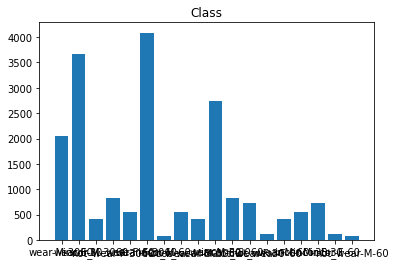

In [13]:
import random
random.shuffle(train_dataset.image_paths)
mask_dict, age_dict,age_group_dict, gender_dict, class_dict = data_dist(train_dataset.image_paths)
# for idx in train_dataset.indices['val']:
#     print(train_dataset.image_paths[idx])
print(sum(mask_dict.values()))
print(sum(age_dict.values()))
print(sum(age_group_dict.values()))
print(sum(gender_dict.values()))
print(sum(class_dict.values()))


## Class
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Class')
plt.show()


18900


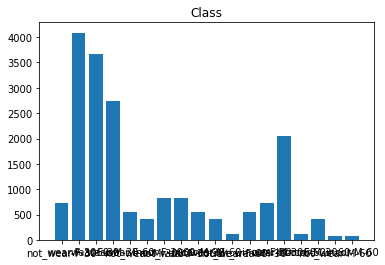

In [14]:
import random
random.shuffle(train_dataset.image_paths)
# 이름이 바뀌네
mask_dict, age_dict,age_group_dict, gender_dict, class_dict = data_dist(train_dataset.image_paths)
## Class
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Class')
plt.show()

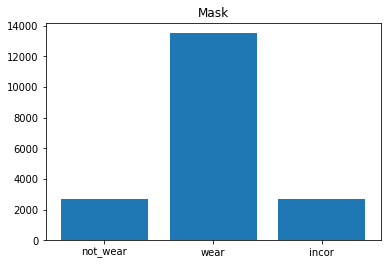

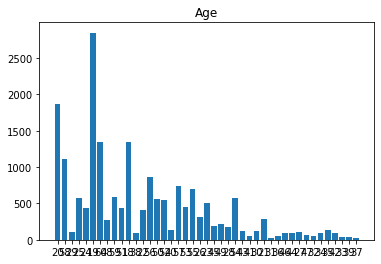

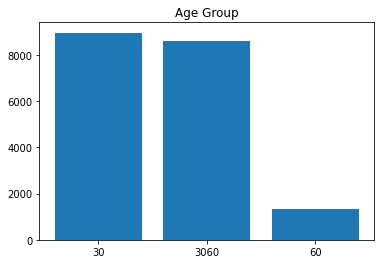

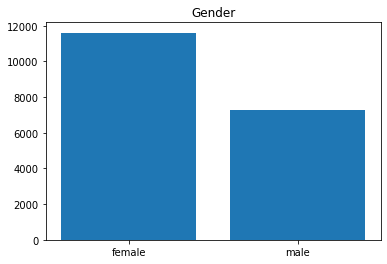

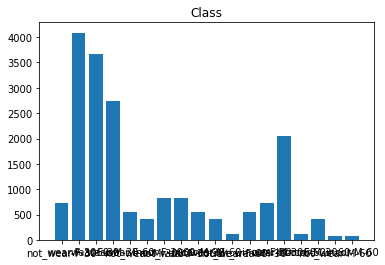

In [15]:
# Total train plot

## MASK
plt.bar(range(len(mask_dict)), list(mask_dict.values()), align='center')
plt.xticks(range(len(mask_dict)), list(mask_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Mask')
plt.show()

## AGE
plt.bar(range(len(age_dict)), list(age_dict.values()), align='center')
plt.xticks(range(len(age_dict)), list(age_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Age')
plt.show()

## AGE GROUP
plt.bar(range(len(age_group_dict)), list(age_group_dict.values()), align='center')
plt.xticks(range(len(age_group_dict)), list(age_group_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Age Group')
plt.show()

## Gender
plt.bar(range(len(gender_dict)), list(gender_dict.values()), align='center')
plt.xticks(range(len(gender_dict)), list(gender_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Gender')
plt.show()

## Class
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Class')
plt.show()

plt.show()

In [16]:
mask_dict

defaultdict(int, {'not_wear': 2700, 'wear': 13500, 'incor': 2700})

In [17]:
train_mask_dict, train_age_dict,train_age_group_dict, train_gender_dict, train_class_dict = data_dist(train_dataset.image_paths[:15505])
print(sum(train_mask_dict.values()))
print(sum(train_age_dict.values()))
print(sum(train_age_group_dict.values()))
print(sum(train_gender_dict.values()))
print(sum(train_class_dict.values()))

15505
15505
15505
15505
15505
15505


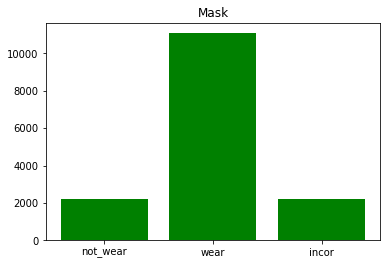

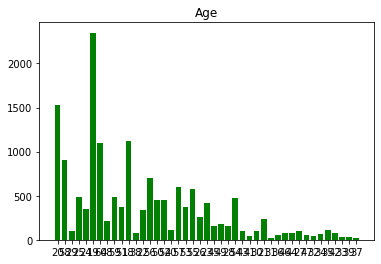

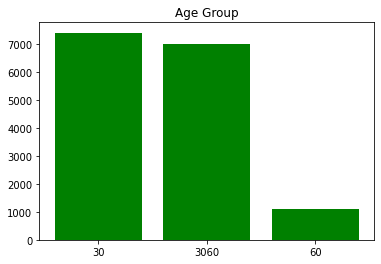

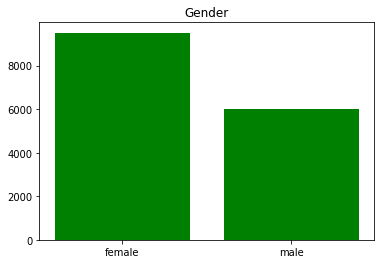

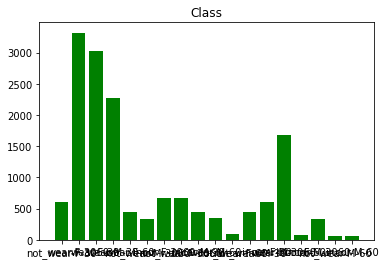

In [18]:
# train split plot

## MASK
plt.bar(range(len(train_mask_dict)), list(train_mask_dict.values()), align='center',color='green')
plt.xticks(range(len(train_mask_dict)), list(train_mask_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Mask')
plt.show()

## AGE
plt.bar(range(len(train_age_dict)), list(train_age_dict.values()), align='center',color='green')
plt.xticks(range(len(train_age_dict)), list(train_age_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Age')
plt.show()

## AGE GROUP
plt.bar(range(len(train_age_group_dict)), list(train_age_group_dict.values()), align='center',color='green')
plt.xticks(range(len(train_age_group_dict)), list(train_age_group_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Age Group')
plt.show()

## Gender
plt.bar(range(len(train_gender_dict)), list(train_gender_dict.values()), align='center',color='green')
plt.xticks(range(len(train_gender_dict)), list(train_gender_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Gender')
plt.show()

## Class
plt.bar(range(len(train_class_dict)), list(train_class_dict.values()), align='center',color='green')
plt.xticks(range(len(train_class_dict)), list(train_class_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Class')
plt.show()

plt.show()

3395
3395
3395
3395
3395
3395


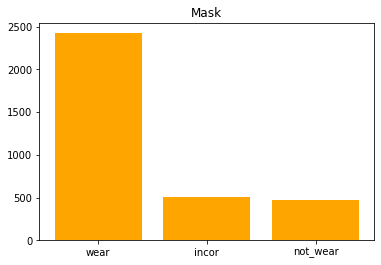

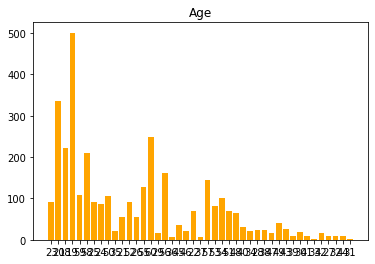

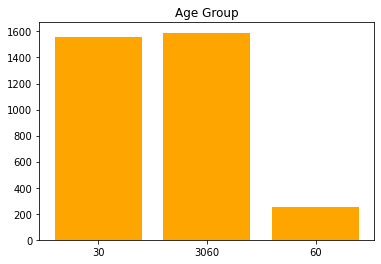

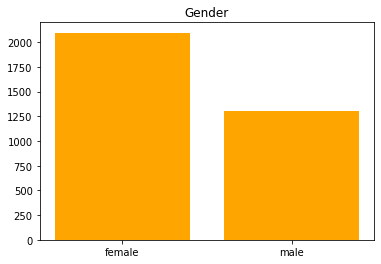

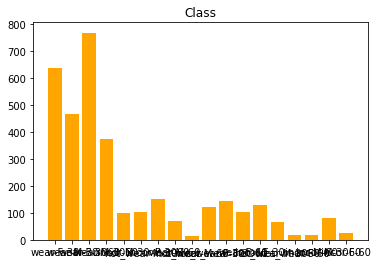

In [19]:
val_mask_dict, val_age_dict,val_age_group_dict, val_gender_dict, val_class_dict = data_dist(train_dataset.image_paths[15505:])
print(sum(val_mask_dict.values()))
print(sum(val_age_dict.values()))
print(sum(val_age_group_dict.values()))
print(sum(val_gender_dict.values()))
print(sum(val_class_dict.values()))

# train split plot

## MASK
plt.bar(range(len(val_mask_dict)), list(val_mask_dict.values()), align='center',color='orange')
plt.xticks(range(len(val_mask_dict)), list(val_mask_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Mask')
plt.show()

## AGE
plt.bar(range(len(val_age_dict)), list(val_age_dict.values()), align='center',color='orange')
plt.xticks(range(len(val_age_dict)), list(val_age_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Age')
plt.show()

## AGE GROUP
plt.bar(range(len(val_age_group_dict)), list(val_age_group_dict.values()), align='center',color='orange')
plt.xticks(range(len(val_age_group_dict)), list(val_age_group_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Age Group')
plt.show()

## Gender
plt.bar(range(len(val_gender_dict)), list(val_gender_dict.values()), align='center',color='orange')
plt.xticks(range(len(val_gender_dict)), list(val_gender_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Gender')
plt.show()

## Class
plt.bar(range(len(val_class_dict)), list(val_class_dict.values()), align='center',color='orange')
plt.xticks(range(len(val_class_dict)), list(val_class_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Class')
plt.show()

plt.show()

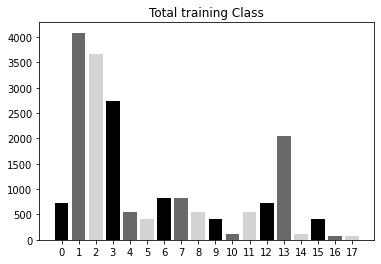

dict_keys(['not_wear-F-30', 'wear-F-3060', 'wear-F-30', 'wear-M-30', 'wear-F-60', 'not_wear-M-3060', 'incor-F-3060', 'not_wear-F-3060', 'incor-M-30', 'wear-M-60', 'not_wear-F-60', 'not_wear-M-30', 'incor-F-30', 'wear-M-3060', 'incor-F-60', 'incor-M-3060', 'not_wear-M-60', 'incor-M-60'])


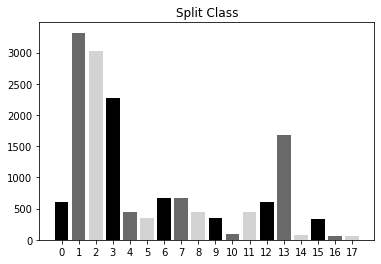

dict_keys(['not_wear-F-30', 'wear-F-3060', 'wear-F-30', 'wear-M-30', 'wear-F-60', 'not_wear-M-3060', 'incor-F-3060', 'not_wear-F-3060', 'incor-M-30', 'wear-M-60', 'not_wear-F-60', 'not_wear-M-30', 'incor-F-30', 'wear-M-3060', 'incor-F-60', 'incor-M-3060', 'not_wear-M-60', 'incor-M-60'])


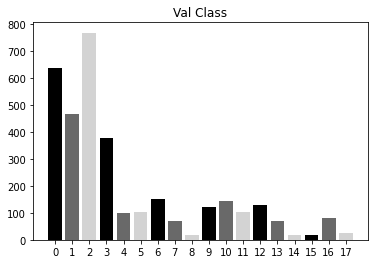

dict_keys(['wear-F-30', 'wear-M-30', 'wear-F-3060', 'wear-M-3060', 'incor-M-30', 'not_wear-M-30', 'incor-F-3060', 'wear-M-60', 'not_wear-M-60', 'not_wear-F-30', 'not_wear-F-3060', 'wear-F-60', 'incor-F-30', 'not_wear-M-3060', 'not_wear-F-60', 'incor-M-60', 'incor-M-3060', 'incor-F-60'])


In [20]:
TRUE_LABELS = ['0_wear-M-30', '1_wear-M-3060','2_wear-M-60',
                   '3_wear-F-30', '4_wear-F-3060','5_wear-F-60',
                   '6_incor-M-30', '7_incor-M-3060','8_incor-M-60',
                   '9_incor-F-30', '10_incor-F-3060','11_incor-F-60',
                   '12_not_wear-M-30', '13_not_wear-M-3060', '14_not_wear-M-60',
                   '15_not_wear-F-30', '16_not_wear-F-3060', '17_not_wear-F-60'
                   ]

LABELS = list(range(18))

colors = [
'black','dimgrey','lightgrey',
'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
    
]


## Class
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center', color = colors)
plt.xticks(range(len(class_dict)), LABELS)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Total training Class')
plt.show()
print(class_dict.keys())
## Class
plt.bar(range(len(train_class_dict)), list(train_class_dict.values()), align='center',color = colors)
plt.xticks(range(len(train_class_dict)), LABELS)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Split Class')
plt.show()
print(train_class_dict.keys())
## Class
plt.bar(range(len(val_class_dict)), list(val_class_dict.values()), align='center',color = colors)
plt.xticks(range(len(val_class_dict)), LABELS)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.title('Val Class')
plt.show()
print(val_class_dict.keys())

In [21]:
from collections import OrderedDict
dict(sorted(class_dict.items(), key=lambda kv: kv[1], reverse=True))

{'wear-F-3060': 4085,
 'wear-F-30': 3660,
 'wear-M-30': 2745,
 'wear-M-3060': 2050,
 'incor-F-3060': 817,
 'not_wear-F-3060': 817,
 'not_wear-F-30': 732,
 'incor-F-30': 732,
 'incor-M-30': 549,
 'not_wear-M-30': 549,
 'wear-F-60': 545,
 'wear-M-60': 415,
 'not_wear-M-3060': 410,
 'incor-M-3060': 410,
 'not_wear-F-60': 109,
 'incor-F-60': 109,
 'not_wear-M-60': 83,
 'incor-M-60': 83}

In [22]:


def change_val(value_dict):
    TRUE_LABELS_NAME = ['wear-M-30', 'wear-M-3060','wear-M-60',
               'wear-F-30', 'wear-F-3060','wear-F-60',
               'incor-M-30', 'incor-M-3060','incor-M-60',
               'incor-F-30', 'incor-F-3060','incor-F-60',
               'not_wear-M-30', 'not_wear-M-3060', 'not_wear-M-60',
               'not_wear-F-30', 'not_wear-F-3060', 'not_wear-F-60'
               ]
    LABEL_DICT = {TRUE_LABELS_NAME[k]:k for k in range(len(TRUE_LABELS_NAME))}
    
    result = list(range(len(TRUE_LABELS_NAME)))
    for k, v in value_dict.items():
    
        result[LABEL_DICT[k]] = v
    return result

def data_dist(indices):
   
    mask_dict = defaultdict(int)
    age_dict = defaultdict(int)
    age_group_dict = defaultdict(int)
    gender_dict = defaultdict(int)
    class_dict = defaultdict(int)
    
    for file_path in indices:
        mask_file = file_path.split('/')[-1]
        info_file = file_path.split('/')[-2]
        
        _, gender, race, age = info_file.split('_')
        
        mask_dict[filter_mask(mask_file.split('.')[0])] += 1
        age_dict[age] += 1
        gender_dict[gender] += 1
        age_group_dict[group_age(int(age))] +=1 
        labels = f"{filter_mask(mask_file.split('.')[0])}-{filter_gender(gender)}-{group_age(int(age))}"
        class_dict[labels] += 1
    return mask_dict, age_dict,age_group_dict, gender_dict, class_dict

import random
random.shuffle(train_dataset.image_paths)
plt.figure(figsize=(1,1))

def plot_distr(total_train_image_path,ratio = 0.2):
 
    train_idx = int(len(total_train_image_path)*(1-ratio))

    split_train = total_train_image_path[:train_idx]
    print(total_train_image_path[:5])
    print(split_train[:5])
    
    split_val = total_train_image_path[train_idx:]
    print(f'train: {len(split_train)}, val: {len(split_val)}')
    
    mask_dict, age_dict,age_group_dict, gender_dict, class_dict = data_dist(total_train_image_path)
    train_mask_dict, train_age_dict,train_age_group_dict, train_gender_dict, train_class_dict = data_dist(split_train)
    val_mask_dict, val_age_dict,val_age_group_dict, val_gender_dict, val_class_dict = data_dist(split_val )
    

    LABELS = list(range(18))

    colors = [
    'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',

    ]
    order = False
    if order:
        class_dict = dict(sorted(class_dict.items(), key=lambda kv: kv[1], reverse=True))
        train_class_dict = dict(sorted(train_gender_dict.items(), key=lambda kv: kv[1], reverse=True))
        val_class_dict = dict(sorted(val_class_dict.items(), key=lambda kv: kv[1], reverse=True))
    else:
        class_list = change_val(class_dict)
        train_class_list = change_val(train_class_dict)
        val_class_list = change_val(val_class_dict)
                  
#     ## Class
#     plt.bar(range(len(class_dict)), class_list, align='center', color = colors)
#     plt.xticks(range(len(class_dict)), LABELS)
#     # # for python 2.x:
#     # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
#     # plt.xticks(range(len(D)), D.keys())  # in python 2.x
#     plt.title('Total training Class')
#     plt.show()

#     ## Class
#     plt.bar(range(len(train_class_dict)), train_class_list, align='center',color = colors)
#     plt.xticks(range(len(train_class_dict)), LABELS)
#     # # for python 2.x:
#     # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
#     # plt.xticks(range(len(D)), D.keys())  # in python 2.x
#     plt.title('Split Training Class')
#     plt.show()

    ## Class
    plt.bar(range(len(val_class_dict)), val_class_list, align='center',color = colors)
    plt.xticks(range(len(val_class_dict)), LABELS)
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Split Val Class')
    plt.show()
    print(val_class_list)

<Figure size 72x72 with 0 Axes>

['/opt/ml/input/data/train/images/001535_female_Asian_18/mask4.jpg', '/opt/ml/input/data/train/images/001123_female_Asian_25/incorrect_mask.jpg', '/opt/ml/input/data/train/images/005476_female_Asian_43/mask3.jpg', '/opt/ml/input/data/train/images/005443_female_Asian_23/mask5.jpg', '/opt/ml/input/data/train/images/000356_female_Asian_58/mask4.jpg']
['/opt/ml/input/data/train/images/001535_female_Asian_18/mask4.jpg', '/opt/ml/input/data/train/images/001123_female_Asian_25/incorrect_mask.jpg', '/opt/ml/input/data/train/images/005476_female_Asian_43/mask3.jpg', '/opt/ml/input/data/train/images/005443_female_Asian_23/mask5.jpg', '/opt/ml/input/data/train/images/000356_female_Asian_58/mask4.jpg']
['/opt/ml/input/data/train/images/001535_female_Asian_18/mask4.jpg', '/opt/ml/input/data/train/images/001123_female_Asian_25/incorrect_mask.jpg', '/opt/ml/input/data/train/images/005476_female_Asian_43/mask3.jpg', '/opt/ml/input/data/train/images/005443_female_Asian_23/mask5.jpg', '/opt/ml/input/dat

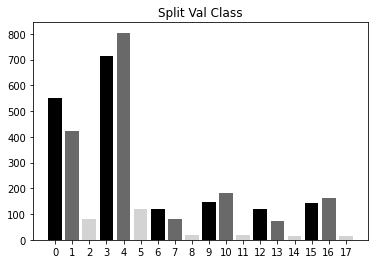

[551, 421, 80, 715, 804, 121, 118, 80, 20, 145, 180, 19, 121, 73, 16, 141, 161, 14]
---
['/opt/ml/input/data/train/images/000216_female_Asian_56/mask4.jpg', '/opt/ml/input/data/train/images/003345_female_Asian_19/mask2.jpg', '/opt/ml/input/data/train/images/001422_male_Asian_58/mask3.jpg', '/opt/ml/input/data/train/images/005406_male_Asian_24/normal.jpg', '/opt/ml/input/data/train/images/005130_female_Asian_29/mask2.jpg']
['/opt/ml/input/data/train/images/000216_female_Asian_56/mask4.jpg', '/opt/ml/input/data/train/images/003345_female_Asian_19/mask2.jpg', '/opt/ml/input/data/train/images/001422_male_Asian_58/mask3.jpg', '/opt/ml/input/data/train/images/005406_male_Asian_24/normal.jpg', '/opt/ml/input/data/train/images/005130_female_Asian_29/mask2.jpg']
['/opt/ml/input/data/train/images/000216_female_Asian_56/mask4.jpg', '/opt/ml/input/data/train/images/003345_female_Asian_19/mask2.jpg', '/opt/ml/input/data/train/images/001422_male_Asian_58/mask3.jpg', '/opt/ml/input/data/train/images/

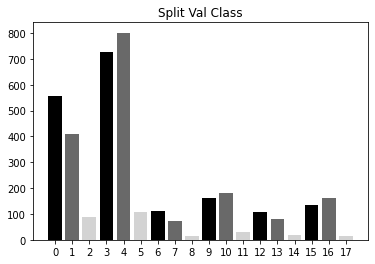

[555, 408, 88, 726, 801, 108, 112, 72, 14, 163, 182, 30, 109, 81, 20, 136, 161, 14]
---
['/opt/ml/input/data/train/images/006407_female_Asian_18/incorrect_mask.jpg', '/opt/ml/input/data/train/images/006542_female_Asian_21/mask3.jpg', '/opt/ml/input/data/train/images/000824_female_Asian_55/mask3.jpg', '/opt/ml/input/data/train/images/005267_male_Asian_21/normal.jpg', '/opt/ml/input/data/train/images/003440_male_Asian_60/incorrect_mask.jpg']
['/opt/ml/input/data/train/images/006407_female_Asian_18/incorrect_mask.jpg', '/opt/ml/input/data/train/images/006542_female_Asian_21/mask3.jpg', '/opt/ml/input/data/train/images/000824_female_Asian_55/mask3.jpg', '/opt/ml/input/data/train/images/005267_male_Asian_21/normal.jpg', '/opt/ml/input/data/train/images/003440_male_Asian_60/incorrect_mask.jpg']
['/opt/ml/input/data/train/images/006407_female_Asian_18/incorrect_mask.jpg', '/opt/ml/input/data/train/images/006542_female_Asian_21/mask3.jpg', '/opt/ml/input/data/train/images/000824_female_Asian_5

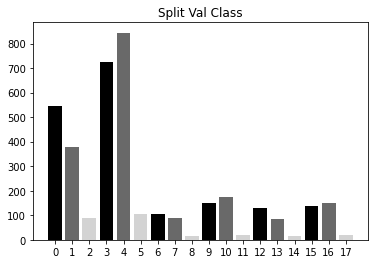

[547, 377, 88, 726, 844, 106, 105, 88, 15, 151, 175, 18, 129, 86, 16, 136, 152, 21]


In [23]:
import random
random.shuffle(train_dataset.image_paths)
print(train_dataset.image_paths[:5]) # 이걸 안하면 안섞이네;;
plot_distr(train_dataset.image_paths)
print('---')
random.shuffle(train_dataset.image_paths)
print(train_dataset.image_paths[:5])
plot_distr(train_dataset.image_paths)
print('---')
random.shuffle(train_dataset.image_paths)
print(train_dataset.image_paths[:5])
plot_distr(train_dataset.image_paths)


In [24]:
random.shuffle(train_dataset.image_paths)
train_dataset.image_paths[:10]

['/opt/ml/input/data/train/images/006589_female_Asian_20/mask1.jpeg',
 '/opt/ml/input/data/train/images/003170_female_Asian_20/mask3.jpg',
 '/opt/ml/input/data/train/images/003418_female_Asian_53/mask2.jpg',
 '/opt/ml/input/data/train/images/000575_male_Asian_55/mask1.jpg',
 '/opt/ml/input/data/train/images/001422_male_Asian_58/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000783_male_Asian_58/mask4.jpg',
 '/opt/ml/input/data/train/images/003397_female_Asian_19/normal.jpg',
 '/opt/ml/input/data/train/images/003529_male_Asian_58/mask3.jpg',
 '/opt/ml/input/data/train/images/005490_female_Asian_42/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/001157_female_Asian_24/mask1.jpg']

In [25]:

def change_val(value_dict):
    TRUE_LABELS_NAME = ['wear-M-30', 'wear-M-3060','wear-M-60',
               'wear-F-30', 'wear-F-3060','wear-F-60',
               'incor-M-30', 'incor-M-3060','incor-M-60',
               'incor-F-30', 'incor-F-3060','incor-F-60',
               'not_wear-M-30', 'not_wear-M-3060', 'not_wear-M-60',
               'not_wear-F-30', 'not_wear-F-3060', 'not_wear-F-60'
               ]
    LABEL_DICT = {TRUE_LABELS_NAME[k]:k for k in range(len(TRUE_LABELS_NAME))}
    
    result = list(range(len(TRUE_LABELS_NAME)))
    for k, v in value_dict.items():
    
        result[LABEL_DICT[k]] = v
    return result

def data_dist(indices):
   
    mask_dict = defaultdict(int)
    age_dict = defaultdict(int)
    age_group_dict = defaultdict(int)
    gender_dict = defaultdict(int)
    class_dict = defaultdict(int)
    
    for file_path in indices:
        mask_file = file_path.split('/')[-1]
        info_file = file_path.split('/')[-2]
        
        _, gender, race, age = info_file.split('_')
        
        mask_dict[filter_mask(mask_file.split('.')[0])] += 1
        age_dict[age] += 1
        gender_dict[gender] += 1
        age_group_dict[group_age(int(age))] +=1 
        labels = f"{filter_mask(mask_file.split('.')[0])}-{filter_gender(gender)}-{group_age(int(age))}"
        class_dict[labels] += 1
    return mask_dict, age_dict,age_group_dict, gender_dict, class_dict

import random
random.shuffle(train_dataset.image_paths)
plt.figure(figsize=(1,1))

def plot_distr(total_train_image_path,ratio = 0.2):
 
    train_idx = int(len(total_train_image_path)*(1-ratio))

    split_train = total_train_image_path[:train_idx]
    print(total_train_image_path[:5])
    print(split_train[:5])
    
    split_val = total_train_image_path[train_idx:]
    print(f'train: {len(split_train)}, val: {len(split_val)}')
    
    mask_dict, age_dict,age_group_dict, gender_dict, class_dict = data_dist(total_train_image_path)
    train_mask_dict, train_age_dict,train_age_group_dict, train_gender_dict, train_class_dict = data_dist(split_train)
    val_mask_dict, val_age_dict,val_age_group_dict, val_gender_dict, val_class_dict = data_dist(split_val )
    

    LABELS = list(range(18))

    colors = [
    'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',

    ]
    order = False
    if order:
        class_dict = dict(sorted(class_dict.items(), key=lambda kv: kv[1], reverse=True))
        train_class_dict = dict(sorted(train_gender_dict.items(), key=lambda kv: kv[1], reverse=True))
        val_class_dict = dict(sorted(val_class_dict.items(), key=lambda kv: kv[1], reverse=True))
    else:
        class_list = change_val(class_dict)
        train_class_list = change_val(train_class_dict)
        val_class_list = change_val(val_class_dict)
                  
#     ## Class
#     plt.bar(range(len(class_dict)), class_list, align='center', color = colors)
#     plt.xticks(range(len(class_dict)), LABELS)
#     # # for python 2.x:
#     # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
#     # plt.xticks(range(len(D)), D.keys())  # in python 2.x
#     plt.title('Total training Class')
#     plt.show()

    ## Class
    plt.bar(range(len(train_class_dict)), train_class_list, align='center',color = colors)
    plt.xticks(range(len(train_class_dict)), LABELS)
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Split Training Class')
    plt.show()
    print(train_class_list)

    ## Class
    plt.bar(range(len(val_class_dict)), val_class_list, align='center',color = colors)
    plt.xticks(range(len(val_class_dict)), LABELS)
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Split Val Class')
    plt.show()
    print(val_class_list)

<Figure size 72x72 with 0 Axes>

['../input/data/train/images/001218_female_Asian_18/normal.jpg', '../input/data/train/images/001332_male_Asian_25/mask1.jpg', '../input/data/train/images/001799_female_Asian_25/mask1.jpg']
['../input/data/train/images/001218_female_Asian_18/normal.jpg', '../input/data/train/images/001332_male_Asian_25/mask1.jpg', '../input/data/train/images/001799_female_Asian_25/mask1.jpg', '../input/data/train/images/005026_male_Asian_60/mask5.jpg', '../input/data/train/images/003705_female_Asian_58/normal.jpg']
['../input/data/train/images/001218_female_Asian_18/normal.jpg', '../input/data/train/images/001332_male_Asian_25/mask1.jpg', '../input/data/train/images/001799_female_Asian_25/mask1.jpg', '../input/data/train/images/005026_male_Asian_60/mask5.jpg', '../input/data/train/images/003705_female_Asian_58/normal.jpg']
train: 15120, val: 3780


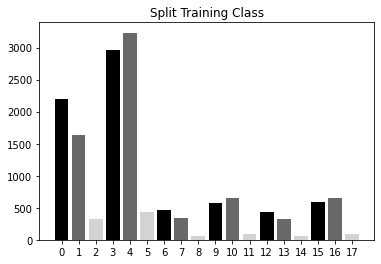

[2200, 1632, 328, 2960, 3232, 433, 463, 333, 67, 573, 646, 89, 437, 331, 61, 590, 660, 85]


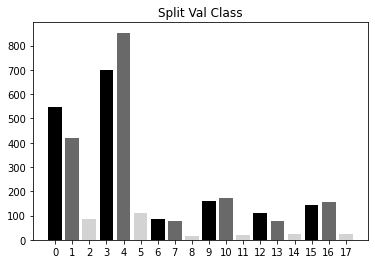

[545, 418, 87, 700, 853, 112, 86, 77, 16, 159, 171, 20, 112, 79, 22, 142, 157, 24]
---
['../input/data/train/images/001142_female_Asian_19/mask5.jpg', '../input/data/train/images/000697_female_Asian_58/mask3.jpg', '../input/data/train/images/000763_female_Asian_55/mask1.jpg']
['../input/data/train/images/001142_female_Asian_19/mask5.jpg', '../input/data/train/images/000697_female_Asian_58/mask3.jpg', '../input/data/train/images/000763_female_Asian_55/mask1.jpg', '../input/data/train/images/004231_female_Asian_60/mask3.jpg', '../input/data/train/images/001813_male_Asian_55/normal.jpg']
['../input/data/train/images/001142_female_Asian_19/mask5.jpg', '../input/data/train/images/000697_female_Asian_58/mask3.jpg', '../input/data/train/images/000763_female_Asian_55/mask1.jpg', '../input/data/train/images/004231_female_Asian_60/mask3.jpg', '../input/data/train/images/001813_male_Asian_55/normal.jpg']
train: 15120, val: 3780


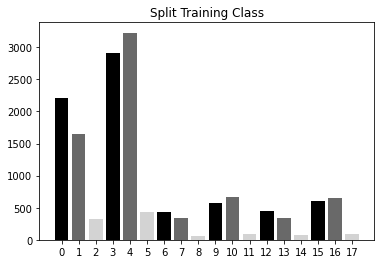

[2215, 1650, 328, 2905, 3227, 427, 437, 333, 59, 576, 672, 88, 454, 338, 69, 597, 657, 88]


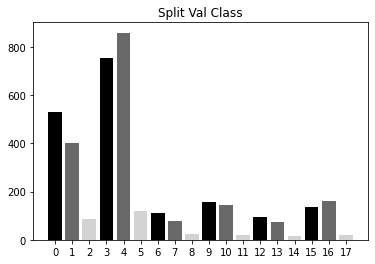

[530, 400, 87, 755, 858, 118, 112, 77, 24, 156, 145, 21, 95, 72, 14, 135, 160, 21]
---


In [26]:
import random
# random.shuffle(train_dataset.image_paths)
train_data_path = glob(os.path.join(data_path,'train','images','*','*'))
random.shuffle(train_data_path)
print(train_data_path[:3]) # 이걸 안하면 안섞이네;;
plot_distr(train_data_path)
print('---')
random.shuffle(train_data_path)
print(train_data_path[:3]) # 이걸 안하면 안섞이네;;
plot_distr(train_data_path)
print('---')

['../input/data/train/images/005141_male_Asian_48/mask5.jpg', '../input/data/train/images/001544_female_Asian_25/mask2.jpg', '../input/data/train/images/006626_male_Asian_19/mask3.jpg', '../input/data/train/images/005429_female_Asian_42/mask4.jpg', '../input/data/train/images/003471_male_Asian_55/normal.jpg']
['../input/data/train/images/005141_male_Asian_48/mask5.jpg', '../input/data/train/images/001544_female_Asian_25/mask2.jpg', '../input/data/train/images/006626_male_Asian_19/mask3.jpg', '../input/data/train/images/005429_female_Asian_42/mask4.jpg', '../input/data/train/images/003471_male_Asian_55/normal.jpg']
train: 3060, val: 340


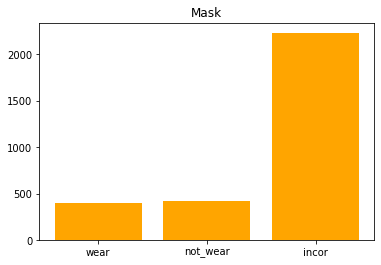

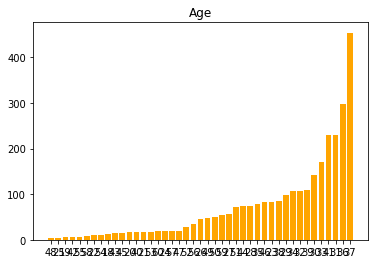

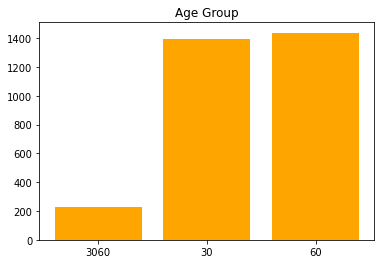

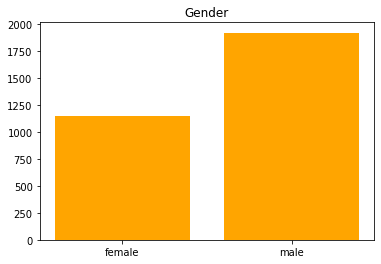

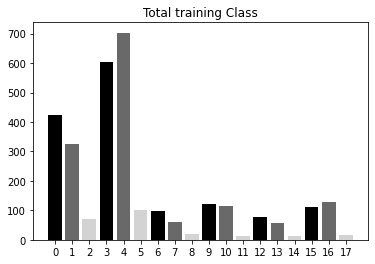

3400


In [27]:
def plot_distr2(total_train_image_path,ratio = 0.2):
 
    train_idx = int(len(total_train_image_path)*(1-ratio))

    split_train = total_train_image_path[:train_idx]
    print(total_train_image_path[:5])
    print(split_train[:5])
    
    split_val = total_train_image_path[train_idx:]
    print(f'train: {len(split_train)}, val: {len(split_val)}')
    
    mask_dict, age_dict,age_group_dict, gender_dict, class_dict = data_dist(split_train)
#     train_mask_dict, train_age_dict,train_age_group_dict, train_gender_dict, train_class_dict = data_dist(split_train)
#     val_mask_dict, val_age_dict,val_age_group_dict, val_gender_dict, val_class_dict = data_dist(split_val )
    

    LABELS = list(range(18))

    colors = [
    'black','dimgrey','lightgrey',
    'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',
        'black','dimgrey','lightgrey',

    ]
    order = False
    if order:
        class_dict = dict(sorted(class_dict.items(), key=lambda kv: kv[1], reverse=True))
        train_class_dict = dict(sorted(train_gender_dict.items(), key=lambda kv: kv[1], reverse=True))
        val_class_dict = dict(sorted(val_class_dict.items(), key=lambda kv: kv[1], reverse=True))
    else:
        class_list = change_val(class_dict)
#         train_class_list = change_val(train_class_dict)
#         val_class_list = change_val(val_class_dict)
  
    ## MASK
    plt.bar(range(len(mask_dict)), sorted(list(mask_dict.values())), align='center',color='orange')
    plt.xticks(range(len(mask_dict)), list(mask_dict.keys()))
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Mask')
    plt.show()

    ## AGE
    plt.bar(range(len(age_dict)), sorted(list(age_dict.values())), align='center',color='orange')
    plt.xticks(range(len(age_dict)), list(age_dict.keys()))
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Age')
    plt.show()

    ## AGE GROUP
    plt.bar(range(len(age_group_dict)), sorted(list(age_group_dict.values())), align='center',color='orange')
    plt.xticks(range(len(age_group_dict)), list(age_group_dict.keys()))
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Age Group')
    plt.show()

    ## Gender
    plt.bar(range(len(gender_dict)), sorted(list(gender_dict.values())), align='center',color='orange')
    plt.xticks(range(len(val_gender_dict)), list(val_gender_dict.keys()))
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Gender')
    plt.show()

    ## Class
    plt.bar(range(len(class_dict)), class_list, align='center', color = colors)
    plt.xticks(range(len(class_dict)), LABELS)
    # # for python 2.x:
    # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
    # plt.xticks(range(len(D)), D.keys())  # in python 2.x
    plt.title('Total training Class')
    plt.show()
    return class_list, mask_dict, age_dict, age_group_dict, gender_dict
#     ## Class
#     plt.bar(range(len(train_class_dict)), train_class_list, align='center',color = colors)
#     plt.xticks(range(len(train_class_dict)), LABELS)
#     # # for python 2.x:
#     # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
#     # plt.xticks(range(len(D)), D.keys())  # in python 2.x
#     plt.title('Split Training Class')
#     plt.show()
#     print(train_class_list)

#     ## Class
#     plt.bar(range(len(val_class_dict)), val_class_list, align='center',color = colors)
#     plt.xticks(range(len(val_class_dict)), LABELS)
#     # # for python 2.x:
#     # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
#     # plt.xticks(range(len(D)), D.keys())  # in python 2.x
#     plt.title('Split Val Class')
#     plt.show()
#     print(val_class_list)
    
a,b,c,d,e = plot_distr2(train_data_path[15500:], ratio=0.1)
print(len(train_data_path[15500:]))

['../input/data/train/images/001142_female_Asian_19/mask5.jpg', '../input/data/train/images/000697_female_Asian_58/mask3.jpg', '../input/data/train/images/000763_female_Asian_55/mask1.jpg', '../input/data/train/images/004231_female_Asian_60/mask3.jpg', '../input/data/train/images/001813_male_Asian_55/normal.jpg']
['../input/data/train/images/001142_female_Asian_19/mask5.jpg', '../input/data/train/images/000697_female_Asian_58/mask3.jpg', '../input/data/train/images/000763_female_Asian_55/mask1.jpg', '../input/data/train/images/004231_female_Asian_60/mask3.jpg', '../input/data/train/images/001813_male_Asian_55/normal.jpg']
train: 3060, val: 340


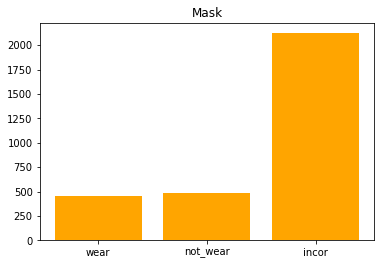

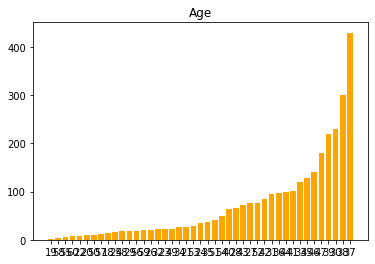

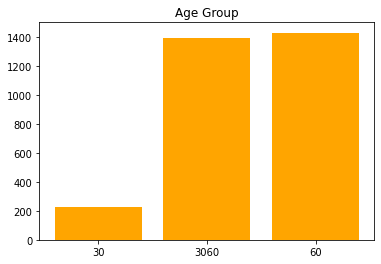

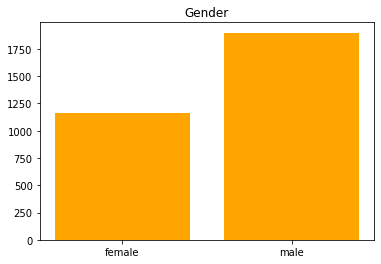

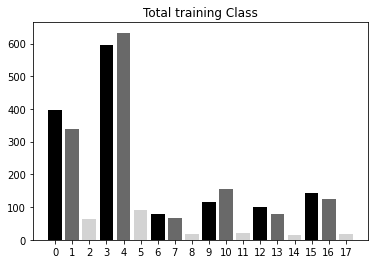

In [28]:
a2,b2,c2,d2,e2 = plot_distr2(train_data_path[:3400], ratio=0.1)

In [29]:
print(a,a2)
print()
print(b,b2)
print()
print(c,c2)
print()
print(d,d2)
print()
print(e,e2)

[425, 324, 69, 605, 703, 102, 98, 61, 18, 122, 116, 12, 77, 58, 12, 111, 130, 17] [398, 339, 65, 594, 633, 92, 80, 67, 17, 117, 156, 20, 100, 79, 16, 144, 124, 19]

defaultdict(<class 'int'>, {'wear': 2228, 'not_wear': 405, 'incor': 427}) defaultdict(<class 'int'>, {'wear': 2121, 'not_wear': 482, 'incor': 457})

defaultdict(<class 'int'>, {'48': 51, '25': 83, '19': 454, '42': 12, '55': 107, '58': 171, '22': 73, '54': 109, '18': 229, '43': 20, '45': 27, '20': 298, '40': 18, '21': 55, '53': 74, '60': 230, '24': 56, '57': 106, '47': 14, '52': 82, '56': 143, '26': 47, '49': 46, '50': 86, '59': 99, '27': 11, '51': 75, '44': 20, '28': 34, '35': 20, '46': 17, '23': 78, '38': 14, '29': 20, '34': 17, '32': 9, '39': 7, '30': 17, '33': 6, '41': 7, '31': 3, '36': 10, '37': 5}) defaultdict(<class 'int'>, {'19': 429, '58': 180, '55': 119, '60': 229, '22': 64, '20': 299, '50': 76, '57': 127, '18': 219, '25': 94, '48': 36, '29': 22, '56': 140, '59': 96, '26': 49, '32': 9, '23': 84, '49': 28, '34': 18,

In [30]:
a,b,c,d,e

([425,
  324,
  69,
  605,
  703,
  102,
  98,
  61,
  18,
  122,
  116,
  12,
  77,
  58,
  12,
  111,
  130,
  17],
 defaultdict(int, {'wear': 2228, 'not_wear': 405, 'incor': 427}),
 defaultdict(int,
             {'48': 51,
              '25': 83,
              '19': 454,
              '42': 12,
              '55': 107,
              '58': 171,
              '22': 73,
              '54': 109,
              '18': 229,
              '43': 20,
              '45': 27,
              '20': 298,
              '40': 18,
              '21': 55,
              '53': 74,
              '60': 230,
              '24': 56,
              '57': 106,
              '47': 14,
              '52': 82,
              '56': 143,
              '26': 47,
              '49': 46,
              '50': 86,
              '59': 99,
              '27': 11,
              '51': 75,
              '44': 20,
              '28': 34,
              '35': 20,
              '46': 17,
              '23': 78,
              '38': 1